**Scraping data from an Edmunds car forum to give advice/insights to brand, product, and advertising managers for future success in their respective car brand companies. As an analytics consultant, I draw conclusions as to what car brands people are mostly talking about and attributes that are associated with them.**



https://forums.edmunds.com/discussion/4119/general/x/project-cars-you-get-to-vote-on-hold-em-or-fold-em/p

---



In [1]:
import pandas as pd
import numpy as np
import re

import sys
sys.path.insert(0,'')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [2]:
cars = pd.read_csv("car_models_and_brands.csv")
aspirational_phrases = cars[-26:]
car_brand = cars["model"].unique()
cars_dict = cars.set_index('model').to_dict()
cars_dict = cars_dict['brand']

In [26]:
def model_replace(s):
    for key in cars_dict:
        if key in s:
            s = s.replace(key, cars_dict[key])
            s = re.sub(r"\b{}\b".format(cars_dict[key]), str(cars_dict[key]), s)
    return s

In [4]:
page_range = (range(1,120))
comments = pd.DataFrame(columns = ['Date','user_id','comments']) 

# initialize dictionary
from collections import defaultdict
from selenium import common

car_freq = defaultdict(int)

driver = webdriver.Chrome('/Users/DRNPRO/Documents/chromedriver', options=chrome_options)

#driver.set_page_load_timeout(20) # set whatever time out limit you want

for page in page_range:
    try:
        driver.get('https://forums.edmunds.com/discussion/4119/general/x/project-cars-you-get-to-vote-on-hold-em-or-fold-em/p' + str(page))
        ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
        comment_ids = []
        for i in ids:
            comment_ids.append(i.get_attribute('id'))

        for x in comment_ids:
            #Extract dates from for each user on a page
            user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
            date = user_date.get_attribute('title')

            #Extract user ids from each user on a page
            userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
            userid = userid_element.text

            #Extract Message for each user on a page
            user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
            comment = user_message.text

            #Adding date, userid and comment for each user in a dataframe    
            comments.loc[len(comments)] = [date,userid,comment]

    except common.exceptions.TimeoutException:
        continue # go onto next page / itteration of forloop

for i in range((comments.shape[0])): 
    comments.loc[i,'comments'] = comments.loc[i,'comments'].lower()

comments.to_csv('raw_data.csv')

print("Edmunds data exported to raw_data.csv")

Edmunds data exported to raw_data.csv


In [27]:
df = pd.read_csv('raw_data.csv')
# replacing car models with the brand name
df['comments'] = df['comments'].astype(str).map(model_replace)
text = df['comments']
text

0       okay, whaddya think about this for $1,000? (i'...
1       save the useful trim pieces and obscure bits\n...
2       because i kinda like those things. the body ac...
3       c'mon andre, you're not following the rules (b...
4       that i think it should be saved, but i'm not g...
                              ...                        
5745                 oh the humanity part ii\n\ncrackhead
5746    oops. seller accidentally added an extra zero ...
5747    sureee it is. just like when i go bargin shopp...
5748    my mom had a silver '79 for the longest time -...
5749    bimmer for $8k over retail\n\nwhen clones go b...
Name: comments, Length: 5750, dtype: object

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

CountVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')

# transform the vectorized count
Count_data = CountVec.fit_transform(text)
 
#create dataframe of the counts for each word
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())

In [29]:
# function to only change the word counts to be 1 per comments
def count_fix(s):
    if s > 1:
        return 1
    else:
        return s

In [30]:
# changing the counts to just count words once per comment
bow_counts = cv_dataframe.applymap(count_fix)

In [31]:
# function to sum the mention counts of each word
def sum_words(s):
    return sum(s)


In [32]:
# summing the word frequencies
freqs = bow_counts.apply(sum_words).sort_values(ascending = False)

# storing frequency counts in csv file
freqs.to_csv('frequencies.csv')
freqs[:10]

car       2780
like      1779
just      1243
think     1196
good       860
really     843
don        829
old        764
nice       704
looks      687
dtype: int64

**PRINT FREQUENCY TABLE (1x10)**






In [33]:
# list of the top ten cars mentioned and the top five cars mentioned
top_ten = ['chevrolet', 'ford', 'porsche', 'mercedes', 'dodge', 'honda', 'toyota', 'chrysler', 'pontiac', 'bmw']
top_five = ['chevrolet', 'ford', 'porsche', 'mercedes', 'dodge']

top_ten_bow = bow_counts[top_ten]
top_five_bow = bow_counts[top_five]

# top five mentioned attributes
top_att = ['engine', 'price', 'interior', 'hp','rust']

# create car brands matrix 
brand_matrix = pd.DataFrame(columns = top_ten)
for cars in top_ten:
    brand_matrix = brand_matrix.append(pd.Series(0, index=brand_matrix.columns), ignore_index=True)
brand_matrix['cars'] = top_ten
brand_matrix = brand_matrix.set_index('cars')

In [34]:
# calculate lift function
def calc_lift(a, b):
    total_size = len(df)
    filter_a = df[df['comments'].str.contains(a)]
    num_a = len(filter_a)
    num_b = len(df[df['comments'].str.contains(b)])
    num_a_b = len(filter_a['comments'][filter_a['comments'].str.contains(b)])
    return total_size*float(num_a_b)/float(num_a*num_b)


In [38]:
## halfing functions
def half_lift(df):
    i = 0
    while i < len(df.columns):
        j = 0
        while j < i + 1:
            if i == j:
                df[df.columns[j]][df.index[i]] = ' '
            else:
                df[df.columns[j]][df.index[i]] = ' ' 
            j += 1
        i += 1
    return df

def half_mds(df):
    i = 0
    while i < len(df.columns):
        j = 0
        while j < i + 1:
            if i == j:
                df[df.columns[j]][df.index[i]] = 0
            else:
                df[df.columns[j]][df.index[i]] = ' '
            j += 1
        i += 1
    return df

In [39]:
# calculate lift between brands
import copy

df = df.dropna(how='any')
lift_matrix = copy.deepcopy(brand_matrix)

for brand1, series in list(lift_matrix.iterrows()):
    for brand2 in series.index:
        lift_matrix[brand2].loc[brand1] = calc_lift(brand1, brand2)

print('Lift matrix of brands:')
dissimilarity = copy.deepcopy(lift_matrix)
half_lift(lift_matrix)

Lift matrix of brands:


,chevrolet,ford,porsche,mercedes,dodge,honda,toyota,chrysler,pontiac,bmw
cars,,,,,,,,,,
chevrolet,,2.52313,1.36662,0.993664,2.2944,1.77111,1.4203,1.67895,2.59056,1.42105
ford,,,1.23745,1.04692,2.20205,1.52676,1.49798,2.91582,1.98406,0.872865
porsche,,,,2.56001,1.27826,1.46087,1.16096,0.4836,0.522324,1.2064
mercedes,,,,,0.998264,0.855655,1.40531,0.566502,0.152966,2.47312
dodge,,,,,,1.66377,1.723,3.40787,2.25864,0.966062
honda,,,,,,,1.57012,2.47845,1.78461,1.67451
toyota,,,,,,,,1.70701,1.64869,1.10553
chrysler,,,,,,,,,3.10152,2.5584
pontiac,,,,,,,,,,0.828978


**Task B**.


I extracted unstructured data from an Edmunds forum titled “Project Cars -- You Get to Vote on ‘Hold ‘em or Fold ‘em’” and found the top ten car brands that users were posting about in order to offer beneficial insights to car brand managers. After extracting the comments from the forum and isolating the occurence of brand names, I calculated lift ratios to determine which car brands were most commonly associated with one another. I found that Chrysler and Dodge were the two most commonly associated car brands (lift = 3.40787). This makes sense considering the two brands are owned by the same company, Fiat Chrysler Automobiles, though it still merits investigation to determine whether those comments were simply talking about the brand or comparing two very different cars. Chrysler was involved with an entirely separate car brand in Pontiac (lift = 3.10152), which merited the second-highest association. Given that Pontiac's associate with Chevrolet (lift = 2.59056) was the third highest, this likely tells us that users were discussing Pontiac's attributes versus that of other brands more often than most other car brands. As Pontiac is a defunct car brand, and the forum is dedicated to determining whether or not to save an old car or sell it, this high association with other brands makes sense.

Given that Pontiac is a defunct brand, I would likely be taking this analysis to a Chrysler or Chevrolet brand manager. Since the associations were high with Pontiac, it would be reasonable to assume commenters were suggesting that owners of Pontiacs should look into the purchase of either a Chevrolet or Chrysler instead of keeping their old Pontiac. Taking a deep dive into these comments to understand why this might be the case should prove useful to the brand manager of either Chrysler or Chevrolet, as it will give them insights into why owners of their cars would suggest them to other people, or why customers in the market for a new car would consider Chrysler or Chevrolet following the purchase of a Pontiac.


In [40]:
dissimilarity = 1/dissimilarity
dissimilarity_matrix = copy.deepcopy(dissimilarity)
print('Lift dissimilarity matrix of brands:')
half_mds(dissimilarity_matrix)

Lift dissimilarity matrix of brands:


,chevrolet,ford,porsche,mercedes,dodge,honda,toyota,chrysler,pontiac,bmw
cars,,,,,,,,,,
chevrolet,0,0.396334,0.73173,1.00638,0.435844,0.564617,0.704075,0.595611,0.386017,0.703707
ford,,0,0.808116,0.955184,0.454122,0.654983,0.667566,0.342957,0.504017,1.14565
porsche,,,0,0.390624,0.782311,0.684522,0.861357,2.06783,1.91452,0.828913
mercedes,,,,0,1.00174,1.1687,0.711585,1.76522,6.53739,0.404348
dodge,,,,,0,0.601043,0.580384,0.293439,0.442744,1.03513
honda,,,,,,0,0.636895,0.403478,0.560348,0.597191
toyota,,,,,,,0,0.585819,0.606541,0.904541
chrysler,,,,,,,,0,0.322422,0.39087
pontiac,,,,,,,,,0,1.2063


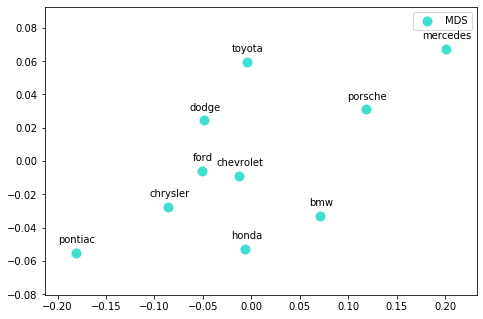

In [41]:
#MDS
import matplotlib.pyplot as plt
from sklearn import manifold

adist = np.array(dissimilarity)
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=7)
results = mds.fit(adist)

coords = results.embedding_

brand_pos = pd.DataFrame(coords).merge(pd.DataFrame(top_ten_bow.columns), left_index=True, right_index=True).set_index('0_y')

s = 100
fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])
xs = coords[:, 0]
ys = coords[:, 1]
plt.scatter(xs, ys, color='turquoise', s=s, lw=0, label='MDS')
count = 0
for x,y in zip(xs,ys):
    label = list(brand_pos.index)
    plt.annotate(label[count], # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(1,10), # distance from text to points (x,y)
                 ha='center')
    count+=1
plt.legend(scatterpoints=1, loc='best', shadow=False)

In [42]:
# car brands-attribute matrix dataframe
model_att = pd.DataFrame(columns = top_att)
for cars in top_ten:
    model_att = model_att.append(pd.Series(0, index=model_att.columns), ignore_index=True)
model_att['cars'] = top_ten
model_att = model_att.set_index('cars')

**Task C**.


To further our analysis for brand managers, I analyzed the unstructured data to find out which attributes were most commonly talked about in relation to our top car brands. This would give brand managers a deeper insight as to what people typically enjoy, or may not enjoy, about their cars. I found that engine, price, interior, horse power (hp), rust, junk, save, and bad were the top attributes (based on word frequency). 


In [43]:
# lifts for brand and attributes
df = df.dropna(how='any')

for brand, series in list(model_att.iterrows()):
    for att in series.index:
        model_att[att].loc[brand] = calc_lift(brand, att)
#print('The five attributes we chose to look at are', top_att)


top_att = ['engine','price','interior', 'hp', 'rust']
print('The Top 5 attributes I chose to look at are:')
for att in range(len(top_att)):
    print('{}. '.format(att+1)+top_att[att])
print("")
model_att[:5]

The Top 5 attributes I chose to look at are:
1. engine
2. price
3. interior
4. hp
5. rust



,engine,price,interior,hp,rust
cars,,,,,
chevrolet,1.60448,1.19113,1.69291,2.27892,1.55
ford,1.49718,1.03047,1.07376,1.80681,1.36613
porsche,2.56473,1.75933,0.742031,0.799111,1.75793
mercedes,1.33149,1.57023,1.30385,0.351038,1.37286
dodge,1.71771,1.05551,1.61624,2.43167,2.29406


**Task D**.


As seen above, "engine" was most commonly associated with Porsche, which should be expected given that Porsche is one of only two performance car brands on the list. It is interesting that BMW was not highly associated with engine, an issue that should be analyzed by BMW. It should be noted though, absent a sentiment analysis, it could be that Porsche is known for engine problems and BMW is not, which would explain the difference in the two association values. 

"Price" was most commonly associated with Porsche, another finding that is in line with the price differences of the most frequently discussed car brands. 

"Interior" was most commonly associated with Chevrolet, which, again absent a sentiment analysis, could mean the interior left something to be desired or was a strength of Chevrolet's. 

Horse power ("hp") was most commonly associated with Dodge and Chevrolet. I would assume that this is in relation the trucks and muscle cars that both brands produce, which rely on horse power as an appealing attribute. However, assumptions are never as good as analysis. The truth could be that users are complaining about the lack of horsepower in their Dodge and Chevrolet models, or talking about how it's not important to them, or some other negative sentiment that could be rooted out with bi- and trigram sentiment analysis. 

Finally, "rust" was most commonly associated with Dodge. It is probably safe to assume that rust rarely comes up if it is not an issue, so Dodge would be well served to investigate this.

In [44]:
aspiration = pd.DataFrame(columns = ['aspiration'])
for cars in top_ten:
    aspiration = aspiration.append(pd.Series(0, index=aspiration.columns), ignore_index=True)
aspiration['cars'] = top_ten
aspiration = aspiration.set_index('cars')

df = df.dropna(how='any')

for brand, series in list(aspiration.iterrows()):
    for att in series.index:
        aspiration[att].loc[brand] = calc_lift(brand, att)
        

print('The aspirational phrases I chose to look at are:')
for att in range(len(aspirational_phrases['model'].values)):
    print('{}. '.format(att+1)+aspirational_phrases['model'].values[att])
    
print('\n\nBrand and aspiration lifts:\n')
aspiration


The aspirational phrases I chose to look at are:
1. want to have
2. wish to have
3. want to own
4. love to own
5. love to own
6. need to have
7. would like to have
8. like to own
9. would like
10. dream car
11. kill to
12. would like to buy
13. wish to own
14. love to buy
15. want to buy
16. have to buy
17. need to buy
18. need to own
19. aspirational
20. dream to own
21. dream to have
22. future car
23. in the future
24. own in the future
25. buy in the future
26. aspire


Brand and aspiration lifts:



,aspiration
cars,
chevrolet,1.12188
ford,0.545541
porsche,2.262
mercedes,0.883257
dodge,1.20758
honda,1.6101
toyota,1.84256
chrysler,1.9188
pontiac,0.518111


**Task E**.


Our last analysis consisted of us reviewing which car brand was most aspirational. To determine this, I searched through our forum's contents and attempted to identify the use of the bi- and tri-grams listed above. From this analysis, I can conclude that Porsche was the most aspirational as it’s co-occurrence with our chosen bi- and trigrams was most signficant.

A brand manager from Porsche should be happy with this analysis, as it shows that those who are deciding to either keep their old car or sell it, are more likely to be considering the purchase of a Porsche than any other car brand. What the brand manager should do from here is determine if the discussion is centering around used Porsches or new Porsches. While it is not a bad thing that customers would see value in purchasing a used Porsche, because it indicates that the cars Porsche produces age well, it doesn't do anything for the bottom like of the company. Finding ways to entice new customers should be the goal of any further analysis.